## NLP_sentiment_analysis


# Using NLP, spaCy, Random Forest, Logistic Regression, XGBoost
# for movie sentiment analysis

Kaggle "Bag of Words Meets Bags of Popcorn" competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from scipy.stats import gmean

import xgboost as xgb
from sklearn.grid_search import GridSearchCV

%matplotlib inline

import KaggleWord2VecUtility

/Users/howardjai/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/howardjai/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Set up spaCy
from spacy.en import English
parser = English()

In [3]:
# Read labeled Training Data - movie reviews
# Read Test data - movie reviews
train = pd.read_csv('labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('testData.tsv', header=0, delimiter='\t', quoting=3)

In [7]:
negators = [line.strip() for line in file('./negator.txt','r')]
    
# function to convert raw review to list of words
def review_to_words(raw_review):
    text = BeautifulSoup(raw_review, "lxml").get_text().strip('\"') 
    
    letters_only = re.sub('[^a-zA-Z]',
                         ' ',
                         text)
    
    words = letters_only.lower().split()       # Convert to lower case
    
    stops = set(stopwords.words("english"))
    
    meaningful_words = [w for w in words if not w in stops or w in negators]
#    meaningful_words = [w for w in words if not w in stops]

#    return(" ".join(meaningful_words))
    return meaningful_words # returns a list of words 


In [8]:
num_reviews = train.shape[0]

clean_train_reviews = []

# clean all reviews
for i in range(0, num_reviews):
    if i % 1000 == 0:
        print 'cleaning review #%d out of %d'%(i, num_reviews)
    
    clean_train_reviews.append(review_to_words(train['review'][i]))

cleaning review #0 out of 25000
cleaning review #1000 out of 25000
cleaning review #2000 out of 25000
cleaning review #3000 out of 25000
cleaning review #4000 out of 25000
cleaning review #5000 out of 25000
cleaning review #6000 out of 25000
cleaning review #7000 out of 25000
cleaning review #8000 out of 25000
cleaning review #9000 out of 25000
cleaning review #10000 out of 25000
cleaning review #11000 out of 25000
cleaning review #12000 out of 25000
cleaning review #13000 out of 25000
cleaning review #14000 out of 25000
cleaning review #15000 out of 25000
cleaning review #16000 out of 25000
cleaning review #17000 out of 25000
cleaning review #18000 out of 25000
cleaning review #19000 out of 25000
cleaning review #20000 out of 25000
cleaning review #21000 out of 25000
cleaning review #22000 out of 25000
cleaning review #23000 out of 25000
cleaning review #24000 out of 25000


In [9]:
review_vectors = []

#  create average word vectors
for i,review in enumerate(clean_train_reviews):
    if i % 1000 == 0:
        print 'vectorizing review #{} of {}'.format(i,len(clean_train_reviews))
    word_vec_list = []
    for word in review:
        word_vec_list.append(parser.vocab[word].vector)
    
    word_vec_matrix = np.matrix(word_vec_list)
    del word_vec_list
    
    review_vectors.append(np.mean(word_vec_matrix, axis=0).tolist()[0])
    
review_matrix = np.asmatrix(review_vectors)

vectorizing review #0 of 25000
vectorizing review #1000 of 25000
vectorizing review #2000 of 25000
vectorizing review #3000 of 25000
vectorizing review #4000 of 25000
vectorizing review #5000 of 25000
vectorizing review #6000 of 25000
vectorizing review #7000 of 25000
vectorizing review #8000 of 25000
vectorizing review #9000 of 25000
vectorizing review #10000 of 25000
vectorizing review #11000 of 25000
vectorizing review #12000 of 25000
vectorizing review #13000 of 25000
vectorizing review #14000 of 25000
vectorizing review #15000 of 25000
vectorizing review #16000 of 25000
vectorizing review #17000 of 25000
vectorizing review #18000 of 25000
vectorizing review #19000 of 25000
vectorizing review #20000 of 25000
vectorizing review #21000 of 25000
vectorizing review #22000 of 25000
vectorizing review #23000 of 25000
vectorizing review #24000 of 25000


In [10]:
# dataframe with movie reviews as average word vectors
avg_df = pd.concat(objs=[train[['id','sentiment']],pd.DataFrame(data=review_vectors)], axis=1)

In [11]:
################# Split Training and Testing models - #######################

In [12]:
from random import shuffle

# function to split dataframe into training and test dataframes
def split_train_test( df, test_portion=0.3 ):
    # create random list of indices
    N = len(df)
    l = range(N)
    shuffle(l)

    # get splitting indicies
    trainLen = int(N*(1-test_portion))

    # get training and test sets
    train = df.ix[l[:trainLen]]
    test = df.ix[l[trainLen:]]

    return train, test

In [13]:
# split dataframe into training and test dataframes
train_df, test_df = split_train_test(avg_df, test_portion=0.3)

In [14]:
# Create training and test data

X_train = train_df.ix[:, 2:].values
y_train = train_df.ix[:, 1].values   #.reshape(1,-1)

X_test = test_df.ix[:, 2:].values
y_test = test_df.ix[:, 1].values    #.reshape(1,-1)

In [15]:
#### Random Forest #####
# rf = RandomForestClassifier(n_estimators=100,verbose=1) # AUC : 0.8164
# rf = RandomForestClassifier(n_estimators=300,verbose=1) # AUC : 0.824

In [16]:
# rf = RandomForestClassifier(n_estimators=100,verbose=1) # AUC : 0.8164
rf = RandomForestClassifier(n_estimators=300,verbose=1) # AUC : 0.8217

forest = rf.fit(X_train, y_train)

# test results from RandomForest
results = forest.predict(X_test)

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished


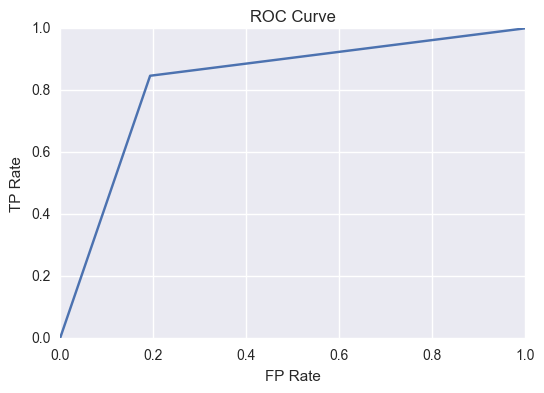

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, results)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')


In [18]:
print 'AUC :', round(auc(fpr, tpr), 4)

AUC : 0.8266


In [19]:
#### XGBoost ############
# xgbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05) # AUC : 0.8395
# xgbm = xgb.XGBClassifier(max_depth=2, n_estimators=300, learning_rate=0.05) # AUC : 0.8301
# xgbm = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05) # AUC : 0.8427

In [20]:
#### XGBoost ############
xgbm = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05)
xgbm.fit(X_train, y_train)
xgbm_predictions = xgbm.predict(X_test)

AUC : 0.8536


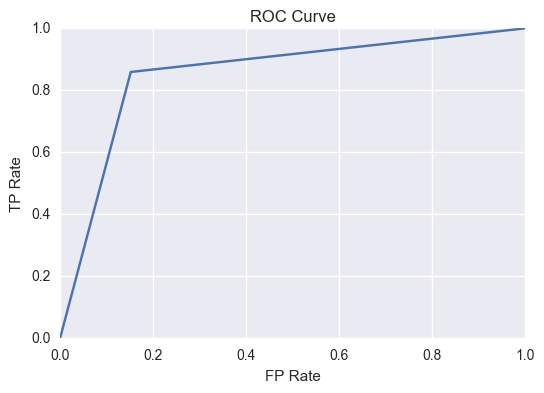

In [21]:
xgbm_fpr, xgbm_tpr, xgbm_thresholds = roc_curve(y_test, xgbm_predictions)
plt.plot(xgbm_fpr, xgbm_tpr)
plt.title('ROC Curve')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')

print 'AUC :', round(auc(xgbm_fpr, xgbm_tpr), 4)

In [22]:
print 'AUC :', round(auc(xgbm_fpr, xgbm_tpr), 4)

AUC : 0.8536


In [23]:
print type(xgbm_predictions)
print xgbm_predictions.shape
xgbm_predictions[0]

<type 'numpy.ndarray'>
(7500,)


1

In [24]:
#### Logistic Regression with Regularation #########
# lr = LogisticRegression(penalty='l2') # AUC : 0.8602

In [25]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
y_lr_prob = lr.predict_proba(X_test)

AUC : 0.864


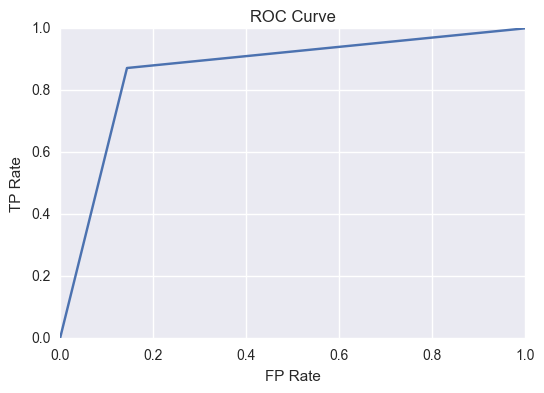

In [26]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_predictions)
plt.plot(lr_fpr, lr_tpr)
plt.title('ROC Curve')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')

print 'AUC :', round(auc(lr_fpr, lr_tpr), 4)

In [27]:
############### END: Split Training and Testing models #######################

In [28]:
############### FINAL: Full Training and Testing models #######################

In [29]:
X_train_1 = avg_df.ix[:, 2:].values
y_train_1 = avg_df.ix[:, 1].values#.reshape(1,-1)

X_test_1 = avg_df.ix[:, 2:].values

In [30]:
# ----- RANDOM FOREST ------#
#rf = RandomForestClassifier(n_estimators=150, verbose=1, n_jobs=3)
rf = RandomForestClassifier(n_estimators=300,verbose=1) # AUC : 0.8217

forest = rf.fit(X=X_train_1, y=y_train_1)

RF_proba = forest.predict_proba(X=X_test_1)


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.7s finished


In [31]:
# ----- XGBOOST ------#
#xgbc = xgb.XGBClassifier(n_estimators=100)
xgbc = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05) # AUC : 0.8427

xgbc.fit(X=X_train_1, y=y_train_1, verbose=True)

XGB_proba = xgbc.predict_proba(X_test_1)


In [32]:
# ----- LOGISTIC REGRESSION ------#
#lr = LogisticRegression()
lr = LogisticRegression(penalty='l2') # AUC : 0.8602

lr.fit(X=X_train_1, y=y_train_1)

LR_proba = lr.predict_proba(X_test_1)


In [33]:
#--------- CREATE DATAFRAME --------#
from scipy.stats import gmean

# create combined ensemble of movie sentiment analysis results
#name = 'combined' # note - combined made Kaggle score:  scored 0.49972
name = 'LR_RF'
mean = 'gmean'
# mean = 'amean'

if name == 'combined':
    proba_class1 = np.matrix((RF_proba[:, 1], LR_proba[:, 1], XGB_proba[:, 1]))
elif name == 'LR_RF':
    proba_class1 = np.matrix((RF_proba[:, 1], LR_proba[:, 1]))

if mean == 'gmean':    
    proba_class1 = np.ravel(gmean(proba_class1,axis=0))
elif mean == 'amnea':
    proba_class1 = np.ravel(np.mean(proba_class1,axis=0))

predictions = map(lambda x: 1 if x > 0.5 else 0, proba_class1)


result_df = pd.concat(objs=[pd.DataFrame(data=test['id']), pd.DataFrame(predictions)], axis=1)
result_df.rename(columns={0:'sentiment'},inplace=True)
result_df['id'] = result_df['id'].apply(lambda x: x.strip("\""))

# Write prediction results to csv file
result_df.to_csv('train_'+ 'spacy_'+ name + '_' + mean + '_predictions.csv', index=False)


In [34]:
#name = 'combined'                 # note - combined made Kaggle score:  scored 0.49972
#name = 'LR_RF'  , mean = 'gmean'  # note - combined made Kaggle score:  scored 0.86020